Omniglot dataset loaded.
Training samples: 19280
Test samples: 13180
Image shape: torch.Size([1, 105, 105])
Label: 0


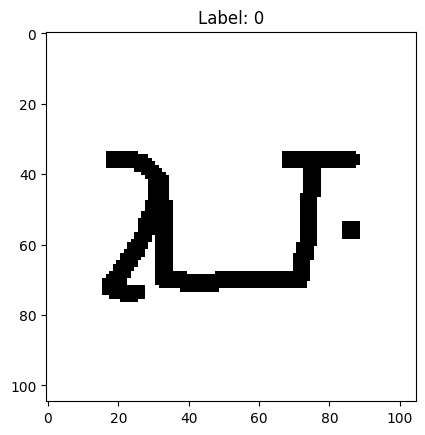

In [1]:
import torch
from torchvision import datasets, transforms
import numpy as np
import random
import matplotlib.pyplot as plt

# Define a transformation to convert images to tensors and normalize
# The paper uses 105x105 images. Torchvision provides them at this size.
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Download and load the training data
# Note: Omniglot's 'background' set is for training, 'evaluation' is for testing.
omniglot_train = datasets.Omniglot(
    root="./data",
    background=True,  # Use the background set for training
    transform=transform,
    download=True
)

omniglot_test = datasets.Omniglot(
    root="./data",
    background=False, # Use the evaluation set for testing
    transform=transform,
    download=True
)


print(f"Omniglot dataset loaded.")
print(f"Training samples: {len(omniglot_train)}")
print(f"Test samples: {len(omniglot_test)}")

image, label = omniglot_train[0]
print("Image shape:", image.shape) # Shape: [Channels, Height, Width]
print("Label:", label)

plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"Label: {label}")
plt.show()

In [2]:
from torch.utils.data import Dataset, DataLoader
class SiameseOmniglot(Dataset):
    """
    A custom dataset for creating pairs of images for the Siamese network.
    It will generate a positive pair (same class) or a negative pair
    (different class) for each sample.
    """
    def __init__(self,omniglot_dataset):
        self.omniglot_dataset=omniglot_dataset
        self.labels = np.array([label for _, label in self.omniglot_dataset])
        self.label_map = {label: np.where(self.labels == label)[0] for label in np.unique(self.labels)}
        
    def __len__(self):
        return len(self.omniglot_dataset)
    
    def __getitem__(self, index):
        img1, label1 = self.omniglot_dataset[index]

        # Randomly decide whether to create a positive (1) or negative (0) pair
        should_get_positive = random.randint(0, 1)

        if should_get_positive:
            # Get a second image from the SAME class
            positive_indices = self.label_map[label1]
            idx2 = random.choice(positive_indices)
            # Ensure the second image is not the same as the first
            while idx2 == index:
                idx2 = random.choice(positive_indices)
            img2, _ = self.omniglot_dataset[idx2]
            label = torch.tensor(1.0) # Label for "same class" is 1
        else:
            # Get a second image from a DIFFERENT class
            negative_label = random.choice(list(self.label_map.keys()))
            while negative_label == label1:
                negative_label = random.choice(list(self.label_map.keys()))

            negative_indices = self.label_map[negative_label]
            idx2 = random.choice(negative_indices)
            img2, _ = self.omniglot_dataset[idx2]
            label = torch.tensor(0.0) # Label for "different class" is 0

        return img1, img2, label

In [3]:
siamese_train_dataset = SiameseOmniglot(omniglot_train)
siamese_test_dataset = SiameseOmniglot(omniglot_test)

In [4]:
train_dataloader = DataLoader(siamese_train_dataset,
                            shuffle=True,
                            batch_size=64) # Batch size can be tuned

test_dataloader = DataLoader(siamese_test_dataset,
                            shuffle=False,
                            batch_size=64)

In [5]:
# Get one batch from the dataloader
img1_batch, img2_batch, labels_batch = next(iter(train_dataloader))

# Get the first pair from the batch
img1, img2, label = img1_batch[0], img2_batch[0], labels_batch[0]

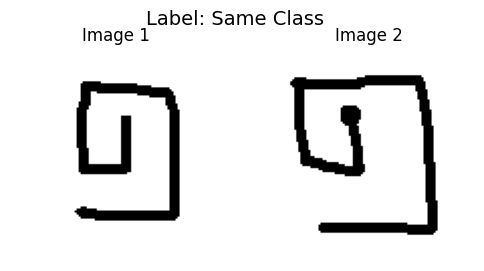

In [6]:
# Visualize the pair
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
ax1.imshow(img1.squeeze(), cmap='gray')
ax1.set_title('Image 1')
ax1.axis('off')
ax2.imshow(img2.squeeze(), cmap='gray')
ax2.set_title('Image 2')
ax2.axis('off')
plt.suptitle(f'Label: {"Same Class" if label == 1.0 else "Different Class"}', fontsize=14)
plt.show()


In [13]:
import torch.nn as nn

class SiameseNN(nn.Module):
    def __init__(self):
        super(SiameseNN,self).__init__()
        self.cnn = nn.Sequential(
            # Layer 1
            nn.Conv2d(1, 64, kernel_size=10), # Input channels = 1 (grayscale)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            # Layer 2
            nn.Conv2d(64, 128, kernel_size=7),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            # Layer 3
            nn.Conv2d(128, 128, kernel_size=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            # Layer 4
            nn.Conv2d(128, 256, kernel_size=4),
            nn.ReLU(inplace=True),
        )

        # The output of the CNN is a 256x6x6 feature map.
        # We flatten this and pass it to a fully connected layer.
        self.fc = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),
            nn.Sigmoid() # As specified in the paper
        )
        # The final classifier layer takes the distance vector and outputs a similarity score
        self.classifier = nn.Sequential(
            nn.Linear(4096, 1),
            nn.Sigmoid()
        )

    def forward_one(self, x):
        """Passes one image through the twin network to get its feature vector."""
        # Pass input through the convolutional layers
        output = self.cnn(x)
        
        # Flatten the feature map to a 1D vector
        output = output.view(output.size()[0], -1)
        
        # Pass through the fully connected layer to get the final feature vector
        output = self.fc(output)
        return output

    def forward(self, img1, img2):
        """Processes a pair of images."""
        # Get the feature vector for each image in the pair
        feature_vector1 = self.forward_one(img1)
        feature_vector2 = self.forward_one(img2)

        # Calculate the L1 distance between the two feature vectors
        distance = torch.abs(feature_vector1 - feature_vector2)
        
        # Pass the distance to the classifier to get the final similarity score
        similarity_score = self.classifier(distance)
        
        return similarity_score
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SiameseNN().to(device)

print("Siamese Network Model:")
print(model)
print("-" * 20)
print(f"Model is on device: {device}")

Siamese Network Model:
SiameseNN(
  (cnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(10, 10), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (10): ReLU(inplace=True)
  )
  (fc): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): Sigmoid()
  )
  (classifier): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
    (1): Sigmoid()
  )
)
--------------------
Model is on device: cpu


In [14]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [ ]:

num_epochs = 10
print("Starting training...")

for epoch in range(num_epochs):
    model.train() # Set the model to training mode
    running_loss = 0.0

    # Iterate over the training dataset
    for i, (img1, img2, label) in enumerate(train_dataloader, 1):
        # Move tensors to the configured device
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass: compute predicted output by passing inputs to the model
        output = model(img1, img2)

        # Calculate the loss
        loss = loss_fn(output, label.unsqueeze(1))

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Perform a single optimization step (parameter update)
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 50 == 0:  # Print every 50 batches
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i}/{len(train_dataloader)}], Loss: {running_loss / 50:.4f}")
            running_loss = 0.0

print("Finished Training")

# --- 3. Save the trained model (optional) ---
torch.save(model.state_dict(), "siamese_model.pth")
print("Model saved to siamese_model.pth")

Starting training...
Epoch [1/10], Batch [50/302], Loss: 0.6264
Epoch [1/10], Batch [100/302], Loss: 0.5752
Epoch [1/10], Batch [150/302], Loss: 0.5581
Epoch [1/10], Batch [200/302], Loss: 0.5323
Epoch [1/10], Batch [250/302], Loss: 0.4932
Epoch [1/10], Batch [300/302], Loss: 0.4841
Epoch [2/10], Batch [50/302], Loss: 0.4297
Epoch [2/10], Batch [100/302], Loss: 0.3890
Epoch [2/10], Batch [150/302], Loss: 0.3706
Epoch [2/10], Batch [200/302], Loss: 0.3446
Epoch [2/10], Batch [250/302], Loss: 0.3141
Epoch [2/10], Batch [300/302], Loss: 0.3033
Epoch [3/10], Batch [50/302], Loss: 0.2949
Epoch [3/10], Batch [100/302], Loss: 0.2719
Epoch [3/10], Batch [150/302], Loss: 0.2848
Epoch [3/10], Batch [200/302], Loss: 0.2649
Epoch [3/10], Batch [250/302], Loss: 0.2650
Epoch [3/10], Batch [300/302], Loss: 0.2517
Epoch [4/10], Batch [50/302], Loss: 0.2562
Epoch [4/10], Batch [100/302], Loss: 0.2104
Epoch [4/10], Batch [150/302], Loss: 0.2335
Epoch [4/10], Batch [200/302], Loss: 0.2131
Epoch [4/10], B

In [ ]:
model.load_state_dict(torch.load("siamese_model.pth"))
model.eval()
print("Trained model loaded successfully.")
test_labels = np.array([label for _, label in omniglot_test])
unique_labels = np.unique(test_labels)
selected_labels = np.random.choice(unique_labels, size=20, replace=False)

# From the first selected class, pick two images.
# One will be the "test image", the other will be the "correct answer".
label_map_test = {label: np.where(test_labels == label)[0] for label in unique_labels}

class_indices = label_map_test[selected_labels[0]]
anchor_idx, correct_support_idx = np.random.choice(class_indices, size=2, replace=False)

test_image, _ = omniglot_test[anchor_idx]
correct_image, _ = omniglot_test[correct_support_idx]
# Create the "support set" of N=20 images
support_set = []
support_set.append(correct_image) # The first image is the correct one

# Add 19 other "imposter" images from different classes
for label in selected_labels[1:]:
    imposter_idx = np.random.choice(label_map_test[label])
    imposter_image, _ = omniglot_test[imposter_idx]
    support_set.append(imposter_image)

# Shuffle the support set so the correct answer isn't always first
random.shuffle(support_set)


# --- 3. Perform the One-Shot Comparison ---
similarities = []
with torch.no_grad(): # Disable gradient calculation for inference
    # Move test image to the device and add a batch dimension
    test_image_tensor = test_image.unsqueeze(0).to(device)

    for support_image in support_set:
        # Move support image to the device and add a batch dimension
        support_image_tensor = support_image.unsqueeze(0).to(device)

        # Use the model to get the similarity score
        # Note: We are now using the model for inference, not training
        similarity = model(test_image_tensor, support_image_tensor)
        similarities.append(similarity.item())


# --- 4. Get the Prediction ---
prediction_idx = np.argmax(similarities)
prediction_is_correct = (support_set[prediction_idx] == correct_image)


# --- 5. Visualize the Results ---
fig, axes = plt.subplots(3, 7, figsize=(15, 8))
fig.suptitle(f'One-Shot Prediction: {"Correct!" if prediction_is_correct else "Incorrect!"}',
             fontsize=16, color='green' if prediction_is_correct else 'red')

# Plot the test image
ax = axes[0, 3]
ax.imshow(test_image.squeeze(), cmap='gray')
ax.set_title("Test Image")
ax.axis('off')

# Plot the support set images
for i, (ax, img) in enumerate(zip(axes.flat[7:], support_set)):
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f"Sim: {similarities[i]:.2f}", fontsize=10)
    ax.axis('off')
    if i == prediction_idx: # Highlight the model's prediction
        rect = plt.Rectangle(ax.get_position().bounds, edgecolor='blue',facecolor='none', lw=3, transform=fig.transFigure)
        fig.patches.append(rect)
    if img == correct_image: # Highlight the ground truth
        rect = plt.Rectangle(ax.get_position().bounds, edgecolor='green',facecolor='none', lw=3, ls='--', transform=fig.transFigure)
        fig.patches.append(rect)

# Hide unused axes
for i in range(7):
    axes[0, i].axis('off')
    if i < 3 or i > 3: axes[0, i].set_visible(False)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
